In [279]:
import pandas as pd 
import json

with open('DMAS_FLAT_PAGE_META.json', 'r') as f:
    page_meta = json.load(f)

df = pd.DataFrame.from_records(page_meta)
df = df[(df['non_header_lines'] > 0)]
df.reset_index(drop=True, inplace=True)

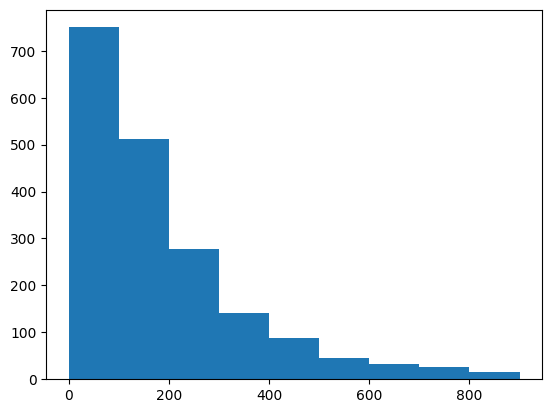

In [280]:
from matplotlib import pyplot 
pyplot.hist(df['tokens'][df['tokens']<2000], bins=range(0, 1_000, 100))
pyplot.show()

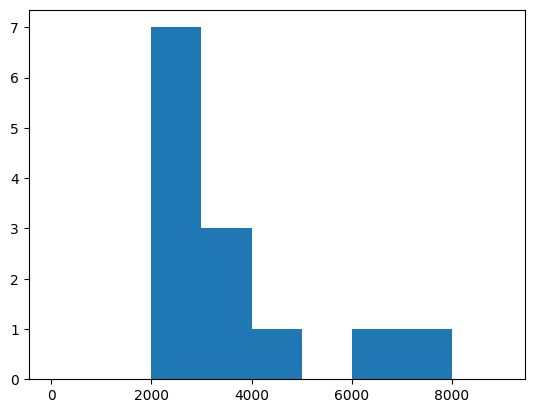

In [281]:
pyplot.hist(df['tokens'][df['tokens']>2000], bins=range(0, 10_000, 1_000))
pyplot.show()

### Merging pages to chunks
Merging pages up to required token size

In [282]:
# sliding window approach
# club pages side by side for small pages

# total toke size
df['tokens'].value_counts(bins=[0, 300, 400, 10000]).sort_index()

(-0.001, 300.0]     1545
(300.0, 400.0]       138
(400.0, 10000.0]     294
Name: count, dtype: int64

In [283]:
N_TOKENS = 350 # 1000 words
CHUNK_SIZE = N_TOKENS
CHUNK_OVERLAP = 0.2*CHUNK_SIZE

N_TOKENS, CHUNK_SIZE, CHUNK_OVERLAP

(350, 350, 70.0)

In [166]:
N_TOKENS*0.85, N_TOKENS*1.15

(297.5, 402.49999999999994)

In [284]:
from functools import lru_cache
from math import inf, pow

def tg2pageIdx(token_groups):
    current_page = 0
    pages = []
    for tg in token_groups:
        pg_grp = []
        for t in tg:
            pg_grp.append(current_page)
            current_page += 1
        pages.append(pg_grp)
    return pages

# add penality if seq_sum is too low 
# we can break higher sized chunks but lower chunks is an issue

objective_function = lambda target, seg_sum: pow(abs(seg_sum - target), 4) if (abs(seg_sum) < N_TOKENS) else pow(abs(seg_sum - target), 2)

def min_error_partition(arr, target):
    """
    Partition a list into contiguous sublists to minimize the sum of squared errors
    between each sublist's sum and a target value.

    Objective minimized: sum((target - sum(segment))**2 for segment in partition)

    Returns:
        parts: list[list[int]] — optimal contiguous partition of arr
        error: float — minimal total squared error
    """
    n = len(arr)
    if n == 0:
        return [], 0.0

    # prefix sums: ps[i] = sum(arr[:i])
    ps = [0] * (n + 1)
    for i in range(n):
        ps[i + 1] = ps[i] + arr[i]

    @lru_cache(maxsize=None)
    def best(i):
        """Best (partition, error) for arr[:i]."""
        if i == 0:
            return tuple(), 0.0

        best_parts = None
        best_err = inf
        # Try last segment arr[k:i] for all k < i
        for k in range(i):
            parts_k, err_k = best(k)
            segment_sum = ps[i] - ps[k]
            cur_err = err_k + objective_function(target, segment_sum)
            if cur_err < best_err:
                best_err = cur_err
                best_parts = parts_k + (tuple(arr[k:i]),)
        return best_parts, best_err

    parts_t, err = best(n)
    parts = [list(seg) for seg in parts_t]
    return parts, err

token_groups, error = min_error_partition(df['tokens'].to_list(), target=N_TOKENS)

In [285]:
token_groups_info = pd.DataFrame(
    {
        'sum': [sum(w) for w in token_groups], 
        'size': [len(w) for w in token_groups], 
        'pages': tg2pageIdx(token_groups)
    }
)

# group_dist = token_groups_info['sum'].value_counts(bins=range(0, 10000, 1000)).sort_index()
# group_dist.plot.bar()

# these are the ones which are merged
tokens_merged = token_groups_info[~(token_groups_info['size']==1)]
tokens_merged.describe()

,sum,size
count,503.000000,503.000000
mean,504.838966,3.407555
std,218.303665,3.608713
min,328.000000,2.000000
25%,392.500000,2.000000
50%,453.000000,3.000000
75%,546.500000,3.000000
max,2402.000000,35.000000


### Breaking bigger Chunks

In [286]:
# strategy
# recursive splitter only!
# sub sequent chunks contains 

print(N_TOKENS, CHUNK_SIZE, CHUNK_OVERLAP)

token_groups_info

350 350 70.0


,sum,size,pages
0,1171,1,[0]
1,445,3,"[1, 2, 3]"
2,695,2,"[4, 5]"
3,438,1,[6]
4,380,2,"[7, 8]"
...,...,...,...
761,347,7,"[1947, 1948, 1949, 1950, 1951, 1952, 1953]"
762,342,8,"[1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961]"
763,374,7,"[1962, 1963, 1964, 1965, 1966, 1967, 1968]"
764,346,7,"[1969, 1970, 1971, 1972, 1973, 1974, 1975]"


In [287]:
token_groups_info['sum'].value_counts(bins=[0, 300, 400, 10000]).sort_index()

(-0.001, 300.0]       0
(300.0, 400.0]      180
(400.0, 10000.0]    586
Name: count, dtype: int64

In [307]:
from typing import Callable, List, Optional, Tuple, Union
import random

OverlapParam = Union[int, float, Tuple[int, int], Callable[[int, int], int], None]

def split_text_by_words(
    text: str,
    min_words: int,
    max_words: int,
    overlap: OverlapParam = None,
    seed: Optional[int] = None,
) -> List[str]:
    """
    Split `text` into chunks with word counts strictly between `min_words` and `max_words`,
    using variable overlap between consecutive chunks.

    Args:
        text: The input text.
        min_words: Lower strict bound for words per chunk (exclusive).
        max_words: Upper strict bound for words per chunk (exclusive).
        overlap:
            - None -> default to 20% of chunk length (at least 1, capped to chunk_len-1)
            - int  -> fixed overlap words
            - float in [0,1) -> fraction of current chunk length
            - (int, int) -> random overlap in inclusive range [min, max]
            - callable (chunk_index, chunk_len) -> int overlap words
        seed: Random seed (used only if `overlap` is a range).

    Returns:
        List[str]: The chunks as strings.

    Notes:
        - Guarantees: For all chunks L, min_words < L < max_words.
        - If the entire text has <= min_words words, returns [] to honor strict bounds.
        - The splitter automatically adjusts overlap to avoid a final too-short chunk.
    """
    if not isinstance(min_words, int) or not isinstance(max_words, int):
        raise TypeError("min_words and max_words must be integers")

    # Strictly between => there must be at least one integer length available
    if max_words - min_words < 2:
        raise ValueError(
            "No valid chunk size exists with strict bounds; require max_words - min_words >= 2"
        )

    # Tokenize by whitespace (simple and fast). If you need punctuation-aware tokenization,
    # you can swap this with a different tokenizer.
    words = text.split()
    n = len(words)

    # If there aren't enough words to make even one valid chunk, return nothing.
    if n <= min_words:
        return []

    rng = random.Random(seed)

    def resolve_overlap(param: OverlapParam, chunk_len: int, chunk_idx: int) -> int:
        """Compute overlap for the *next* transition based on `param`."""
        if param is None:
            v = max(1, int(round(0.20 * chunk_len)))  # default: 20% overlap
        elif isinstance(param, int):
            v = param
        elif isinstance(param, float):
            if not (0.0 <= param < 1.0):
                raise ValueError("Float overlap must be in [0,1)")
            v = int(round(param * chunk_len))
        elif isinstance(param, tuple) and len(param) == 2:
            a, b = param
            if a > b:
                a, b = b, a
            v = rng.randint(a, b)
        elif callable(param):
            v = int(param(chunk_idx, chunk_len))
        else:
            raise TypeError("Unsupported overlap parameter type")

        # Clamp: cannot overlap as many as the whole chunk; require forward progress
        return max(0, min(v, max(0, chunk_len - 1)))

    chunks: List[str] = []
    start = 0
    chunk_idx = 0

    while start < n:
        remaining = n - start
        # Choose the current chunk length within the strict bounds.
        # Prefer the longest valid chunk (greedy) without exceeding max_words - 1.
        L = min(max_words - 1, remaining)

        if L <= min_words:
            # Not enough words remain to form a valid chunk.
            # This can happen only at the very start (n <= min_words) or
            # if previous overlap adjustments already tried to prevent this.
            break

        # Decide overlap for the transition to the next chunk.
        ov = resolve_overlap(overlap, L, chunk_idx)

        # Compute next start position with that overlap.
        next_start = start + L - ov

        # Peek at tail remainder after this choice:
        remainder_after = n - next_start

        # If we'd leave a short tail (0 < remainder <= min_words), increase overlap now
        # to ensure the next chunk can be valid (has at least min_words + 1 words).
        if 0 < remainder_after <= min_words:
            needed = (min_words + 1) - remainder_after  # words to add to the next chunk
            ov_candidate = min(ov + needed, L - 1)
            # Recompute with the adjusted overlap
            next_start_candidate = start + L - ov_candidate
            remainder_after_candidate = n - next_start_candidate
            # Accept if it fixes the tail
            if remainder_after_candidate > min_words:
                ov = ov_candidate
                next_start = next_start_candidate

        # Emit the current chunk
        end = start + L
        chunks.append(" ".join(words[start:end]))

        # Advance
        start = next_start
        chunk_idx += 1

    return chunks
    

In [ ]:
import os 
from glob import glob
for file in glob(r'chunks/*.md'):
    os.remove(file)

# from langchain.text_splitter import CharacterTextSplitter
# splitter = splitter = CharacterTextSplitter.from_tiktoken_encoder(
#     encoding_name="cl100k_base", chunk_size=4*N_TOKENS, chunk_overlap=100
# )

from langchain_text_splitters import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    separators=[' ', '\n'], chunk_size=4*N_TOKENS, chunk_overlap=100, length_function=len, is_separator_regex=False,
)

# split token groups with token sized greater then 400
def read_md_content(page_idx):
    content = ''
    with open('md_content/' + page_meta[page_idx]['md']) as f:
        content += f.read()
    return content

def write_chunk(content, filename):
    with open('chunks/' + filename, 'w') as f:
        f.write(content)
    return

chunk_meta = []
split_chunk_lengths = []

for idx, tg_info in token_groups_info.iterrows():
    # get text and use recursive splitter
    content = ''
    breadcrumbs = []
    for page_idx in tg_info['pages']:
        content_ = [content, read_md_content(page_idx)]
        content = '\n'.join([c for c in content_ if c])
        breadcrumbs.append(page_meta[page_idx]['title'])
    
    if len(content.strip().split()) < 400:
        chunks_iter = [(0, content.strip())]
    else:
        chunks_iter = enumerate(split_text_by_words(content.strip(), min_words=300, max_words=400))
        # chunks_iter = enumerate(splitter.split_text(content.strip()))

    for chunk_idx, chunk_content in chunks_iter:
        filename = 'DMAS_{:04d}.md'.format(len(chunk_meta))
        chunk_length = len(chunk_content.split())
        
        chunk_meta.append(
            {
                'source_pages': tg_info['pages'], 
                'chunk_id': chunk_idx, 
                'breadcrumbs': breadcrumbs,
                'filename': filename,
                'size': chunk_length 
            }
        )
        
        # if chunk_length < 300:
        #     print(idx, tg_info.to_dict())
        #     print(chunk_length, chunk_idx)

        write_chunk(chunk_content, filename)

df_chunks = pd.DataFrame.from_records(chunk_meta)
df_chunks['size'].value_counts(bins=[0, 299, 400, 10000]).sort_index()

(-0.001, 299.0]        4
(299.0, 400.0]      1814
(400.0, 10000.0]       0
Name: count, dtype: int64

In [337]:
with open('DMAS_CHUNK_META.json', 'w') as f:
    json.dump(chunk_meta, f, indent=4)